In [1]:
import pandas as pd
import SDSSdownload as sd
import glob

# astropy will yell about deprecated FITS stuff, as usual
import warnings
warnings.filterwarnings("ignore")

#### Using the Nair & Abraham catalog that we'll be training our bar detection model on, but any RA and Dec will work
##### Available at: http://www.bo.astro.it/~nair/Morphology/Visual_Morphology.html

In [2]:
cat = pd.read_csv("NairAbrahamMorphology.cat", delim_whitespace=True)
cat.columns

Index(['#JID', 'RA', 'DEC', 'z', 'zconf', 'g', 'r', 'M_g', 'L_g', 'Rp_g',
       'Rp50_g', 'Rp90_g', 'spID', 'Mass', 'Age', 'g-r', 'SFRT', 'SFRM',
       'mu_g', 'mu_M', 'M/L', 'Area', 'bOverA', 'seeing_g',
       'NYU-DR4_Object_Tag', 'n_g', 'n_r', 'chi2_g', 'chi2_r', 'R50_n',
       'R90_n', 'V_disp', 'V_disp_Err', 'V/Vmax', 'AGN_Kauffmann',
       'AGN_Kewley', 'groupid', 'Ngroup', 'brightgalflag', 'massivegalflag',
       'Lum_group', 'Mass_group', 'halomass1', 'halomass2', 'rho_nyu',
       'rho_Baldry', 'rhomin_Baldry', 'rhomax_Baldry', 'TType', 'Bar', 'Ring',
       'Ring_flag', 'Lens', 'flag', 'Pairs', 'Pair_flag', 'dist', 'tails',
       'RC3', 'Tt'],
      dtype='object')

In [3]:
i = 4444
ra, dec = cat.RA[i],cat.DEC[i]
ra,dec

(183.921, 65.66)

##### We also need a table from SDSS with object IDs, p90, and redshift (and other values which might be useful for later)

In [4]:
sdss_cat_path = 'SDSS_query.csv'
sdss_cat = pd.read_csv(sdss_cat_path)
sdss_cat.head()

,objID,ra,dec,z,zErr,zWarning,specObjID,expAB_g,run,rerun,...,petroR90_g,petroR90_r,petroR90_i,petroR50_g,petroR50_r,petroR50_i,dered_g,dered_r,dered_i,psffwhm_r
0,1237645879578460271,51.483587,1.272013,0.048765,0.000014,0,466232818830174208,0.863005,94,301,...,5.467532,5.663464,5.895120,1.731266,1.850085,1.998065,17.02536,16.56240,16.33304,1.485923
1,1237645943976493208,50.827079,0.939863,0.036462,0.000010,0,465165741990111232,0.329829,109,301,...,4.804936,4.835532,4.613300,2.314294,2.260115,2.198445,17.04150,16.54225,16.27490,1.199589
2,1237645943978328289,55.053166,0.885909,0.038777,0.000013,0,468485167426594816,0.358346,109,301,...,12.979050,13.054510,8.108786,5.838737,5.604107,4.188865,17.24656,16.84164,16.66606,1.130951
3,1237645943978393694,55.123626,0.872521,0.040687,0.000009,0,468488465961478144,0.226685,109,301,...,19.572440,18.851100,17.552020,6.475946,5.835520,5.221539,16.23023,15.40764,14.94073,1.102439
4,1237645943978590386,55.585464,1.021442,0.037585,0.000012,0,468496712298686464,0.220475,109,301,...,13.524950,12.294050,12.826600,6.066473,5.515994,5.397372,16.70816,16.15367,15.82415,1.255855


In [5]:
# default save directories are /data/ and /images/
test_dir = './test1/'

dl1 = sd.Image(ra,dec,data_dir=test_dir, show_progress=True, df_path=sdss_cat_path)

In [6]:
# We should now have a plate fits file
print(glob.glob(dl1.gal_dir + "*.fits"))

['./test1/1237651067352973432\\cutout_r.fits', './test1/1237651067352973432\\plate_r.fits']


#### By default, downloads the plate in the r filter. We can specify specific bands with bands=[...], or bands='all' for u, g, r, i, and z.

In [7]:
test_dir = './test2/'
dl2 = sd.Image(ra,dec,data_dir=test_dir, bands='all', show_progress=True, df_path=sdss_cat_path)

In [8]:
# Now we should have a fits file for each SDSS filter
print(glob.glob(dl2.gal_dir + "*.fits"))

['./test2/1237651067352973432\\cutout_g.fits', './test2/1237651067352973432\\cutout_i.fits', './test2/1237651067352973432\\cutout_r.fits', './test2/1237651067352973432\\cutout_u.fits', './test2/1237651067352973432\\cutout_z.fits', './test2/1237651067352973432\\plate_g.fits', './test2/1237651067352973432\\plate_i.fits', './test2/1237651067352973432\\plate_r.fits', './test2/1237651067352973432\\plate_u.fits', './test2/1237651067352973432\\plate_z.fits']


#### Next, lets make a cutout

In [9]:
dl1.cutout()

In [10]:
# We should now have a plate fits file and a cutout fits file
print(glob.glob(dl1.gal_dir + "*.fits"))

['./test1/1237651067352973432\\cutout_r.fits', './test1/1237651067352973432\\plate_r.fits']


#### And plot it.

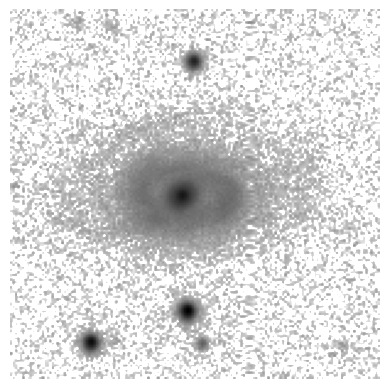

In [11]:
dl1.plot_cutout()

#### Or save the plot (can also save the plot with plot_cutout(save=True)).

In [12]:
dl1.save_plot()

#### To make sure we have an appropriate size of cutout to fit the galaxy, we want something based on the angular size of the galaxy
#### The function size_from_z() will take the Petrosian radius and redshift of the galaxy, and give an angular size

In [13]:
import astropy.units as u
p90 = cat.Rp90_g.values[i]
z = cat.z.values[i]
size = sd.size_from_z(p90, z)

#### Now let's see if this size fits our galaxy

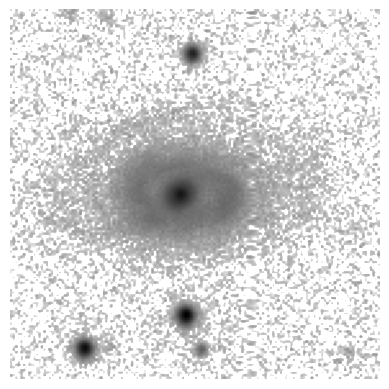

In [14]:
dl1.cutout(size=size)
dl1.plot_cutout()

#### Let's make a color image now
##### Note: have to use colors that were included in the initialization

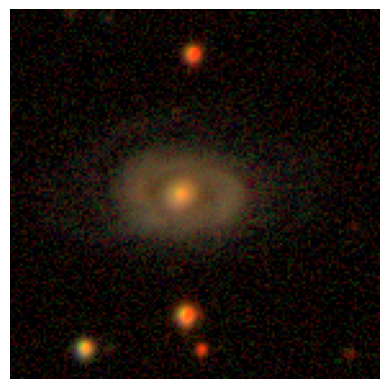

In [15]:
dl2.cutout(size=size)
dl2.plot_cutout_color(red='i',green='r',blue='g')

#### Now we can start downloading

#### Besides saving the data, we want to record the Nair catalog ID and the SDSS ID for crossmatching, and the flag for which targets aren't on the plate

In [21]:
# Create a file to append to as we go
import os
if not os.path.exists('downloaded_galaxies.txt'):
    with open('downloaded_galaxies.txt', "x") as txt:
        txt.write("#JID, objID, on_plate\n")

In [22]:
# Download the first 10 galaxies
new_cat = cat.iloc[0:10]

# Create a new test directory
dir = './test3/'

# For this each of these, we'll download just the i, r, and g filters
bands = ['i','r','g']

for JID, ra, dec, p90, z in zip(new_cat['#JID'], new_cat.RA, new_cat.DEC, new_cat.Rp90_g, new_cat.z):
    # Download and make cutouts
    dl = sd.Image(ra=ra, dec=dec, data_dir=dir, bands=bands, df_path=sdss_cat_path)
    size = sd.size_from_z(p90, z)
    dl.cutout(size=size)

    # Make B&W images for each band
    for band in bands:
        dl.save_plot(band=band)

    # Make a color image
    dl.save_cutout_color(red='i', green='r', blue='g')

    # Append text file with values
    with open('downloaded_galaxies.txt', 'a') as txt:
        txt.write(f"{JID}, {dl.objid}, {dl.on_plate}\n")